## Imports

## Functions

In [11]:
from JSU_lib import *
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

def custom_sort(strings):
    # Function to extract the numeric part of the string
    def extract_number(s):
        num = ''
        for char in s:
            if char.isdigit():
                num += char
            else:
                break
        return int(num) if num else 0

    # Sort the list using the extracted numbers
    sorted_strings = sorted(strings, key=extract_number)
    return sorted_strings

def subset_list_by_indices(data, M):
    N = len(data)
    if M > N:
        raise ValueError("M cannot be greater than the number of elements in the list")
    if M < 2:
        raise ValueError("M should be at least 2 to include both ends")
    
    if M == 2:
        return [data[0], data[-1]]
    if M == N:
        return data[:]
    
    indices = [0]  # Start with the first index
    interval = (N-1) // (M-1)  # Calculate interval
    for i in range(1, M-1):
        indices.append(indices[-1] + interval)
    indices.append(N-1)  # Ensure the last index is N-1

    # Subset the list using the calculated indices
    return [data[index] for index in indices]

def plot_stacked_barplot_f1_ward(df, palette, order = ["VN-EGNN", "IF-SitePred", "GrASP", "DeepPocket", "P2Rank+Cons", "P2Rank", "fpocket"], col = "WARD", DPI = 100):
    ward_counts = df.groupby(['method', col]).size().unstack(fill_value=0)
    ward_counts = ward_counts.div(ward_counts.sum(axis=1), axis=0)
    ward_counts = ward_counts.loc[order]
    
    fig, ax = plt.subplots(figsize=(6, 6), dpi=DPI)
    bottom = np.zeros(len(ward_counts))
    #print(ward_counts)
    for i, ward in enumerate(ward_counts.columns):
        ax.bar(ward_counts.index, ward_counts[ward], bottom=bottom, label=f'{ward}', color = palette[ward], edgecolor="k", linewidth=1)
        bottom += ward_counts[ward]

    ax.set_xticks(range(len(ward_counts.index)))
    ax.set_xticklabels(ward_counts.index, rotation=45, ha="right")
    ax.set_ylabel('p')
    ax.set_xlabel("Method")
    ax.set_ylim(0, 1)
    legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    legend.get_frame().set_edgecolor('black')
    for patch in legend.get_patches():
        patch.set_edgecolor('black')
    plt.xlim(-0.6, len(order)-0.4)
    plt.show()

def plot_roc_curve(df, methods, true_label_col, palette, DPI = 150, out = None):
    plt.figure(figsize=(6, 6), dpi = DPI)
    for method in methods:
        fpr, tpr, _ = roc_curve(df[true_label_col], df[method])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=palette[method], lw=2, label=f'{method} (AUC = {roc_auc:.5f})')

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label = 'Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend().set_visible(True)
    if out != None:
        plt.savefig(out)
    plt.show()

def plot_precision_recall_curve(df, methods, true_label_col, palette, DPI = 150, out = None):
    plt.figure(figsize=(6, 6), dpi = DPI)

    # Calculate the proportion of positive samples (baseline)
    positive_proportion = df[true_label_col].mean()
    #print(positive_proportion)
    
    for method in methods:
        precision, recall, _ = precision_recall_curve(df[true_label_col], df[method])
        avg_precision = average_precision_score(df[true_label_col], df[method])
        plt.plot(recall, precision, color=palette[method], lw=2, label=f'{method} (AP = {avg_precision:.5f})')

    # Plot the baseline
    plt.plot([0, 1], [positive_proportion, positive_proportion], color='k', lw=2, linestyle='--', label='Baseline')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.title('PR Curve')
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.legend().set_visible(True)
    if out != None:
        plt.savefig(out)
    plt.show()

def plot_stacked_bar(data, num_bins, order, DPI = 150, out = None):
    # Bin the scores
    bin_edges = pd.cut(data['score'], bins=num_bins, labels=False, retbins=True)[1]
    data['bin'] = pd.cut(data['score'], bins=bin_edges, labels=False, include_lowest=True)
    
    # Calculate the frequency of scores within each bin for each method
    bin_counts = data.groupby(['method', 'bin']).size().unstack(fill_value=0)
    
    # Normalize the bin counts to make the bars add up to one
    bin_counts = bin_counts.div(bin_counts.sum(axis=1), axis=0)

    #order = ["IF-SitePred", "GrASP", "P2Rank+Cons", "P2Rank"]
    bin_counts = bin_counts.loc[order]
    
    # Define a palette
    palette = sns.color_palette("viridis", num_bins)
    
    # Plot the stacked bar plot
    fig, ax = plt.subplots(figsize=(3, 6), dpi=DPI)
    bin_counts.plot(kind='bar', stacked=True, ax=ax, width=0.75, edgecolor='black', colormap='magma')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Method')
    ax.set_ylabel('p')
    plt.xticks(rotation = 45)

    bin_labels = []
    for i in range(num_bins):
        if i == 0:
            bin_lab = f'[0, {bin_edges[i+1]:.2f})'
        elif i == len(range(num_bins))-1:
            bin_lab = f'[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]'
        else:
            bin_lab = f'[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f})'
        bin_labels.append(bin_lab)
            
    # Customizing the legend
    legend = ax.legend(title='Ligandabilty Score', labels=bin_labels, loc='upper left', bbox_to_anchor=(1, 1))
    legend.get_frame().set_edgecolor('black')
    for patch in legend.get_patches():
        patch.set_edgecolor('black')

    plt.axhline(y = 0.5, linestyle = "--", linewidth = 1,color = "k")

    if out != None:
        plt.savefig(out)
    
    plt.show()

def plot_stacked_bars(df, columns, labels = ["Non-binding", "Binding"], colors = ["lightgrey", "purple"], DPI = 100):
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(6, 6), dpi = DPI)
    
    # Create a dictionary to store the normalized counts for each category in the columns
    category_counts = {col: df[col].value_counts(normalize=True).sort_index() for col in columns}
    
    # Plot a bar for each category
    for i, (method, counts) in enumerate(category_counts.items()):
        ax.bar(i, counts.get(0, 0), label=labels[0] if i == 0 else "", color=colors[0], edgecolor="k", linewidth=1)
        ax.bar(i, counts.get(1, 0), bottom=counts.get(0, 0), label=labels[1] if i == 0 else "", color=colors[1], edgecolor="k", linewidth=1)
    
    # Formatting the plot
    ax.set_xticks(range(len(columns)))
    ax.set_xticklabels([col for col in columns], rotation = 45)  # Capitalize the column names for display
    ax.set_ylabel('p')
    ax.set_xlabel("Method")
    #ax.set_title('Proportion of Binary Ligand Binding Labels')
    legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend to outside of the plot
    legend.get_frame().set_edgecolor('black')
    for patch in legend.get_patches():
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    plt.ylim(0, 1)
    plt.xlim(-0.6, len(columns)-0.4)
    plt.show()

## Input data

In [2]:
combined_df_filt = pd.read_pickle("./results/ALL_PREDS_COMBINED_RIGHT_EXTENDED.pkl")

In [3]:
LIGYSIS_reps = combined_df_filt.query('origin == "LIGYSIS"').rep_chain.unique().tolist()

In [4]:
REF = 'LIGYSIS'

TARGETS = [
    'VN-EGNN',
    'IF-SitePred',
    'GrASP',
    'PUResNet',
    'DeepPocket-Segmented',
    'P2Rank+Cons',
    'P2Rank',
    'fpocket',
    'PocketFinder',
    'Ligsite',
    'Surfnet'
 ]

In [5]:
len(LIGYSIS_reps)

2775

## Generating ligandability dataframe

In [6]:
trans_dir = "./../DATA/trans_rep_chains_V2"
GRASP_preds_dir = "./../DATA/GrASP_PDB_preds_V2"
IFSP_preds_dir = "./results/IFSP_preds"
P2RANK_preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/PROGRAMS/p2rank_2.4.2-beta.1/test_output/predict_trans_rep_chains_V2"
P2RANK_cons_preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/PROGRAMS/p2rank_2.4.2-beta.1/test_output/predict_trans_rep_chains_V2_CONS"
PocketFinder_preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/pocketfinder_preds"
Ligsite_preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/ligsite_preds"
Surfnet_preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/surfnet_preds"

In [7]:
labels_dict = {orig: [] for orig in [REF, ] + TARGETS}
rep_chains, chains, resnums, resnames = [[], [], [], []]

errors = []

for i, rep_chain in enumerate(LIGYSIS_reps):

    rep_chain_preds = combined_df_filt.query('rep_chain == @rep_chain')
    
    try:

        rep_chain_df = PDBXreader(inputfile = os.path.join(trans_dir, f'{rep_chain}.trans.pdb')).atoms(format_type="pdb", excluded=())

        all_ress = rep_chain_df.drop_duplicates(["label_asym_id", "label_seq_id_full", "label_comp_id"])

        all_resnums = all_ress.label_seq_id_full.tolist()
        all_resnames = all_ress.label_comp_id.tolist()
        all_chains = all_ress.label_asym_id.tolist()

        binding_ress_REF = custom_sort(list(set([el for sublist in rep_chain_preds.query('origin == @REF').aas.tolist() for el in sublist])))

        labels_REF = [1 if residue in binding_ress_REF else 0 for residue in all_resnums]

        labels_dict[REF].extend(labels_REF)

        rep_chains.extend([rep_chain]*len(labels_REF))
        chains.extend(all_chains)
        resnums.extend(all_resnums)
        resnames.extend(all_resnames)
        
        for TARGET in TARGETS:

            binding_ress_TARGET = custom_sort(list(set([el for sublist in rep_chain_preds.query('origin == @TARGET').aas.tolist() for el in sublist])))

            labels_TARGET = [1 if residue in binding_ress_TARGET else 0 for residue in all_resnums]

            labels_dict[TARGET].extend(labels_TARGET)

    except:
        raise
        errors.append(rep_chain)

In [8]:
len(errors)

0

In [9]:
data = {
    "rep_chain": rep_chains,
    "chain": chains,
    "resnum": resnums,
    "resname": resnames,
}

# Adding the labels_dict to the data dictionary
data.update(labels_dict)

# Creating the DataFrame
df = pd.DataFrame(data)

In [12]:
df.head()

,rep_chain,chain,resnum,resname,LIGYSIS,VN-EGNN,IF-SitePred,GrASP,PUResNet,DeepPocket-Segmented,P2Rank+Cons,P2Rank,fpocket,PocketFinder,Ligsite,Surfnet
0,1a52_A,A,10,LEU,0,0,0,0,0,1,0,0,1,1,0,0
1,1a52_A,A,11,ALA,0,0,0,0,0,1,0,0,1,1,0,0
2,1a52_A,A,12,LEU,0,0,0,0,0,0,0,0,0,0,0,0
3,1a52_A,A,13,SER,0,0,0,0,0,0,0,0,0,0,0,0
4,1a52_A,A,14,LEU,0,0,0,0,0,1,0,0,1,1,0,0


In [14]:
df.shape

(831572, 16)

In [17]:
df = pd.read_pickle("./results/LIGYSIS_ress_binary_labels.pkl")

In [18]:
keys = list(zip(df['rep_chain'], df['chain'], df['resnum'], df['resname']))
values = df['LIGYSIS'].tolist()
TRUE_labels_dict = dict(zip(keys, values))

In [41]:
df.to_pickle("./results/LIGYSIS_ress_binary_labels.pkl")

## Calculating F1 Scores

In [16]:
# # Initialise a dictionary to store F1 scores
# f1_scores = {
#     "rep_chain": [],
#     "VN-EGNN": [],
#     "IF-SitePred": [],
#     "GrASP": [],
#     'PUResNet': [],
#     "DeepPocket-Segmented": [],
#     "P2Rank": [],
#     "P2Rank+Cons": [],
#     "fpocket": [],
#     'PocketFinder': [],
#     'Ligsite': [],
#     'Surfnet': []
# }

# # Calculate F1 scores for each rep_chain
# for rep_chain, group in df.groupby('rep_chain'):
#     f1_scores["rep_chain"].append(rep_chain)
#     for method in f1_scores.keys():
#         if method != "rep_chain":
#             f1 = f1_score(group["LIGYSIS"], group[method])
#             f1_scores[method].append(f1)

# # Create a DataFrame from the F1 scores dictionary
# f1_scores_df = pd.DataFrame(f1_scores)

In [17]:
# Initialize a list to store F1 scores in a long-form format
f1_scores_long = []

# Calculate F1 scores for each rep_chain
for rep_chain, group in df.groupby('rep_chain'):
    for method in df.columns[5:]:
        f1 = f1_score(group["LIGYSIS"], group[method])
        f1_scores_long.append({
            "rep_chain": rep_chain,
            "method": method,
            "f1_score": f1
        })

# Create a DataFrame from the long-form list
f1_scores_df = pd.DataFrame(f1_scores_long)

In [18]:
len(f1_scores_df.rep_chain.unique())

2775

In [19]:
f1_scores_df.query('f1_score == 0').method.value_counts()

IF-SitePred             931
PUResNet                818
DeepPocket-Segmented    752
P2Rank                  680
GrASP                   572
VN-EGNN                 564
P2Rank+Cons             517
Surfnet                 401
PocketFinder            332
Ligsite                 293
fpocket                 138
Name: method, dtype: int64

In [43]:
f1_scores_df.to_pickle("./results/F1_scores.pkl")

In [2]:
f1_scores_df = pd.read_pickle("./results/F1_scores.pkl")

## Calculating MCC

In [44]:
# # Initialise a dictionary to store F1 scores
# MCCs = {
#     "rep_chain": [],
#     "VN-EGNN": [],
#     "IF-SitePred": [],
#     "GrASP": [],
#     'PUResNet': [],
#     "DeepPocket-Segmented": [],
#     "P2Rank": [],
#     "P2Rank+Cons": [],
#     "fpocket": [],
#     'PocketFinder': [],
#     'Ligsite': [],
#     'Surfnet': []
# }

# # Calculate F1 scores for each rep_chain
# for rep_chain, group in df.groupby('rep_chain'):
#     MCCs["rep_chain"].append(rep_chain)
#     for method in MCCs.keys():
#         if method != "rep_chain":
#             MCC = matthews_corrcoef(group["LIGYSIS"], group[method])
#             MCCs[method].append(MCC)

# # Create a DataFrame from the F1 scores dictionary
# MCCs_df = pd.DataFrame(MCCs)

In [22]:
# Initialize a list to store F1 scores in a long-form format
MCCs_long = []

# Calculate F1 scores for each rep_chain
for rep_chain, group in df.groupby('rep_chain'):
    for method in df.columns[5:]:
        MCC = matthews_corrcoef(group["LIGYSIS"], group[method])
        MCCs_long.append({
            "rep_chain": rep_chain,
            "method": method,
            "MCC": MCC
        })

# Create a DataFrame from the long-form list
MCCs_df = pd.DataFrame(MCCs_long)

In [46]:
MCCs_df.to_pickle("./MCCs.pkl")

In [4]:
MCCs_df = pd.read_pickle("./results_clean/MCCs.pkl")

## Protein cluster analysis for F1 score

In [23]:
prot_class_dict = read_from_pickle("./results/prot_class_dict.pkl")
protein_class_palette = {
    "ELONGATED": "firebrick",
    "ELONGATED+TINY": "orange",
    "GLOBULAR": "purple",
    "GLOBULAR+TINY": "cornflowerblue",
}

In [24]:
f1_scores_df["SHAPE"] = f1_scores_df.rep_chain.map(prot_class_dict)

In [25]:
f1_scores_df_SHAPE = f1_scores_df.query('SHAPE == SHAPE').reset_index(drop = True)

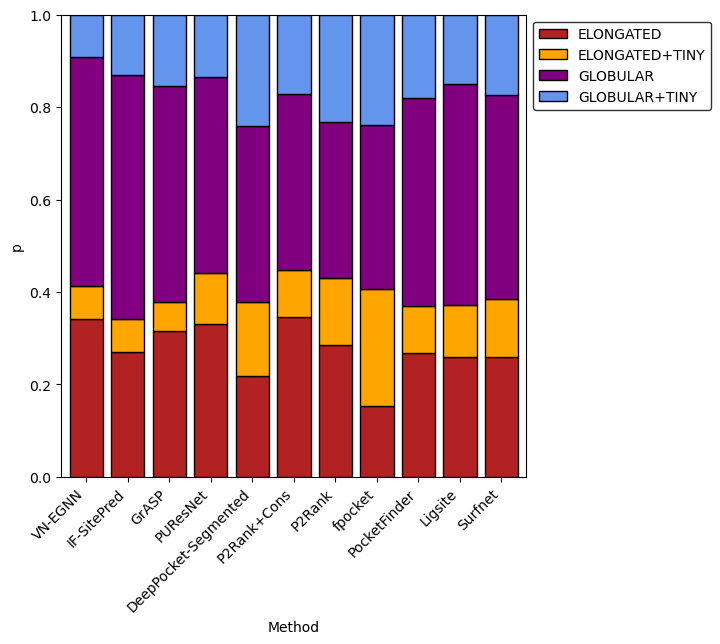

In [51]:
# Call the function with the dataframe
plot_stacked_barplot_f1_ward(f1_scores_df_SHAPE.query('f1_score == 0'), order = TARGETS, col = "SHAPE", palette = protein_class_palette)

## Plotting MCC

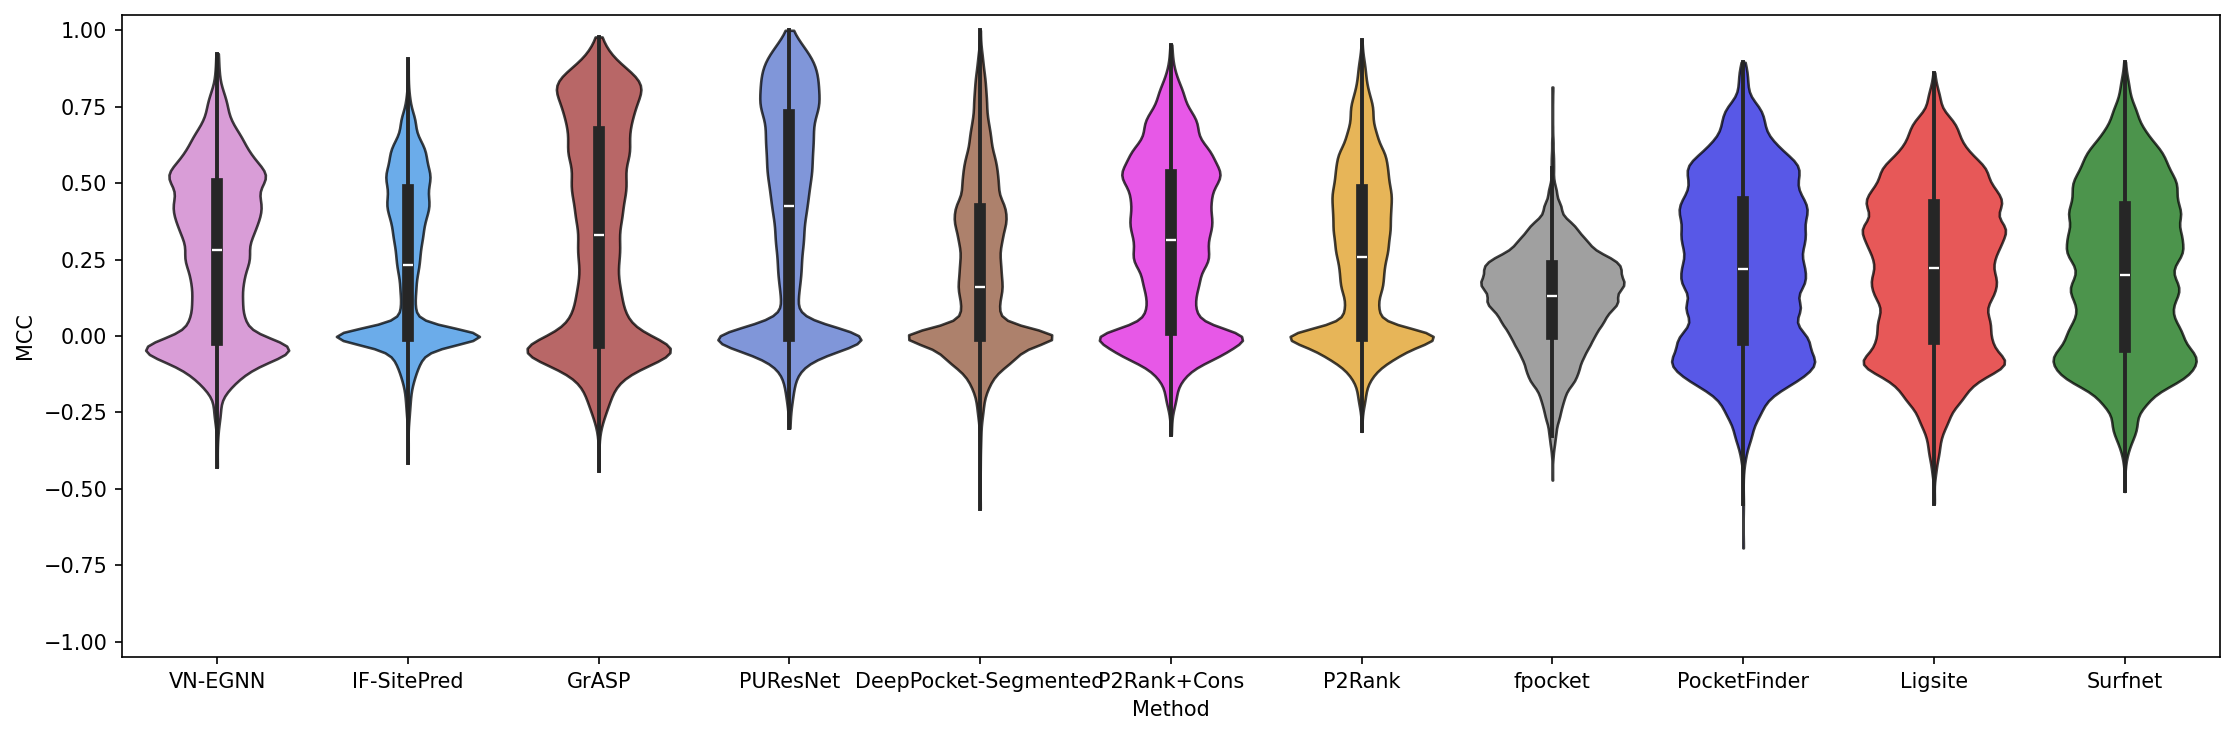

In [52]:
my_order = TARGETS

plt.figure(figsize=(15, 5), dpi=150)
ax = sns.violinplot(
    x="method", y="MCC", data=MCCs_df, palette=palette, cut=0,
    fill=True, linewidth=1.25, width=0.75, order=my_order, bw_adjust=0.5, inner = "box", alpha = 0.75,
)

for violin in ax.collections:
    if isinstance(violin, PolyCollection):
        violin.set_edgecolor('k')  
        facecolor = violin.get_facecolor()
        facecolor[:, -1] = 0.15 
        violin.set_facecolor(facecolor)

plt.xlabel('Method')
plt.ylabel('MCC')

plt.ylim(-1.05, 1.05)
plt.tight_layout()
#plt.savefig("./figs/MCC_violins.png")
plt.show()

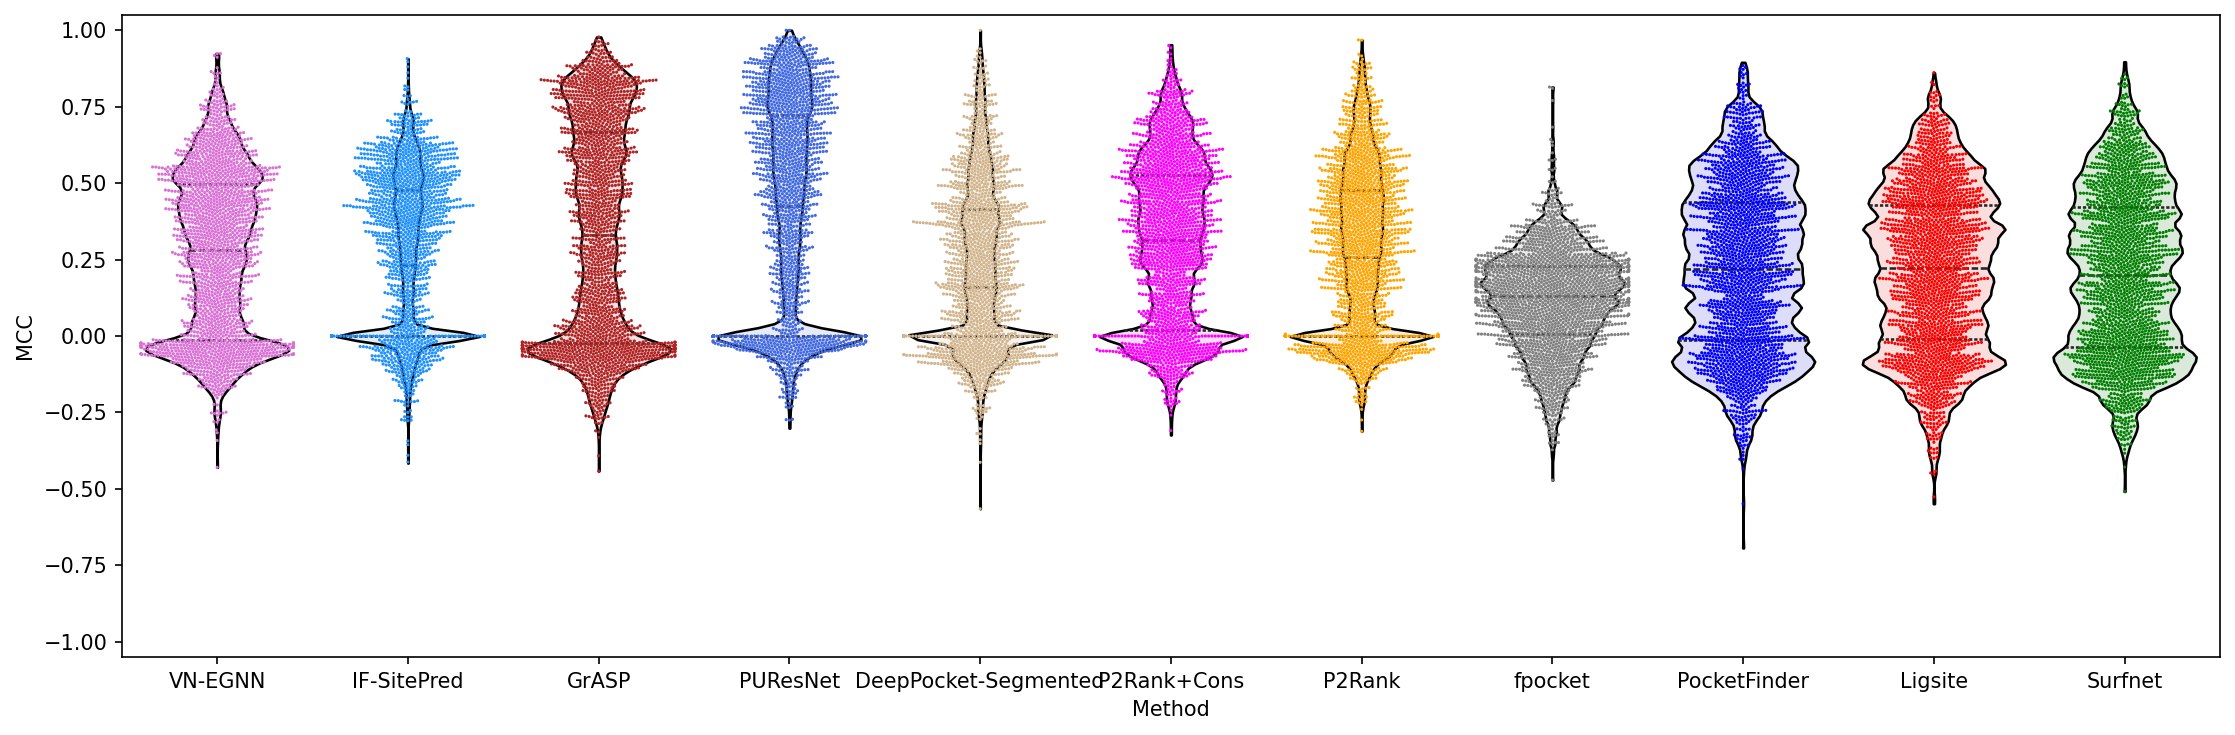

In [83]:
# Subsampling each method to 50 samples (adjust the number as needed)
subsampled_MCCs_df = MCCs_df.groupby('method').apply(lambda x: x.sample(min(2000, len(x)))).reset_index(drop=True)

plt.figure(figsize=(15, 5), dpi=150)
ax = sns.violinplot(
    x="method", y="MCC", data=MCCs_df, palette=palette, cut=0,
    fill=True, linewidth=1.25, width=0.75, order=my_order, bw_adjust=0.3, inner = "quart"
)

# Manually set the edgecolor and facecolor for each violin
for violin in ax.collections:
    if isinstance(violin, PolyCollection):
        violin.set_edgecolor('k')  # Set edge color to black
        facecolor = violin.get_facecolor()
        facecolor[:, -1] = 0.15  # Set alpha for face color
        violin.set_facecolor(facecolor)

# Adding the swarm plot on top
sns.swarmplot(x="method", y="MCC", data=subsampled_MCCs_df, palette=palette, alpha=1, size=1.5, order=my_order)

plt.xlabel('Method')
plt.ylabel('MCC')

plt.ylim(-1.05, 1.05)
plt.tight_layout()
plt.show()

In [58]:
MCCs_df.query('MCC == 0').method.value_counts()

IF-SitePred             700
DeepPocket-Segmented    427
PUResNet                415
P2Rank                  373
P2Rank+Cons             196
fpocket                  17
VN-EGNN                  12
GrASP                     6
Surfnet                   2
PocketFinder              2
Ligsite                   1
Name: method, dtype: int64

In [160]:
f1_scores_df.groupby("method").mean().sort_values("f1_score", ascending = False).round(2)

,f1_score
method,
PUResNet,0.41
GrASP,0.39
P2Rank+Cons,0.36
P2Rank,0.31
PocketFinder,0.31
Ligsite,0.31
Surfnet,0.29
VN-EGNN,0.29
IF-SitePred,0.29


In [7]:
f1_scores_df.groupby("method").mean().sort_values("f1_score", ascending = False).round(5)

,f1_score
method,
PUResNet,0.40581
GrASP,0.38742
P2Rank+Cons,0.35531
P2Rank,0.31250
PocketFinder,0.30688
Ligsite,0.30617
Surfnet,0.29302
VN-EGNN,0.29301
IF-SitePred,0.29080


In [54]:
MCCs_df.groupby("method").mean().sort_values("MCC", ascending = False).round(2)

,MCC
method,
PUResNet,0.39
GrASP,0.34
P2Rank+Cons,0.30
VN-EGNN,0.26
P2Rank,0.26
IF-SitePred,0.24
PocketFinder,0.22
Ligsite,0.21
DeepPocket-Segmented,0.21


In [9]:
MCCs_df.groupby("method").mean().sort_values("MCC", ascending = False).round(4)

,MCC
method,
PUResNet,0.3896
GrASP,0.3351
P2Rank+Cons,0.3012
VN-EGNN,0.2643
P2Rank,0.2637
IF-SitePred,0.2411
PocketFinder,0.2199
Ligsite,0.2146
DeepPocket-Segmented,0.2145


## All F1 scores

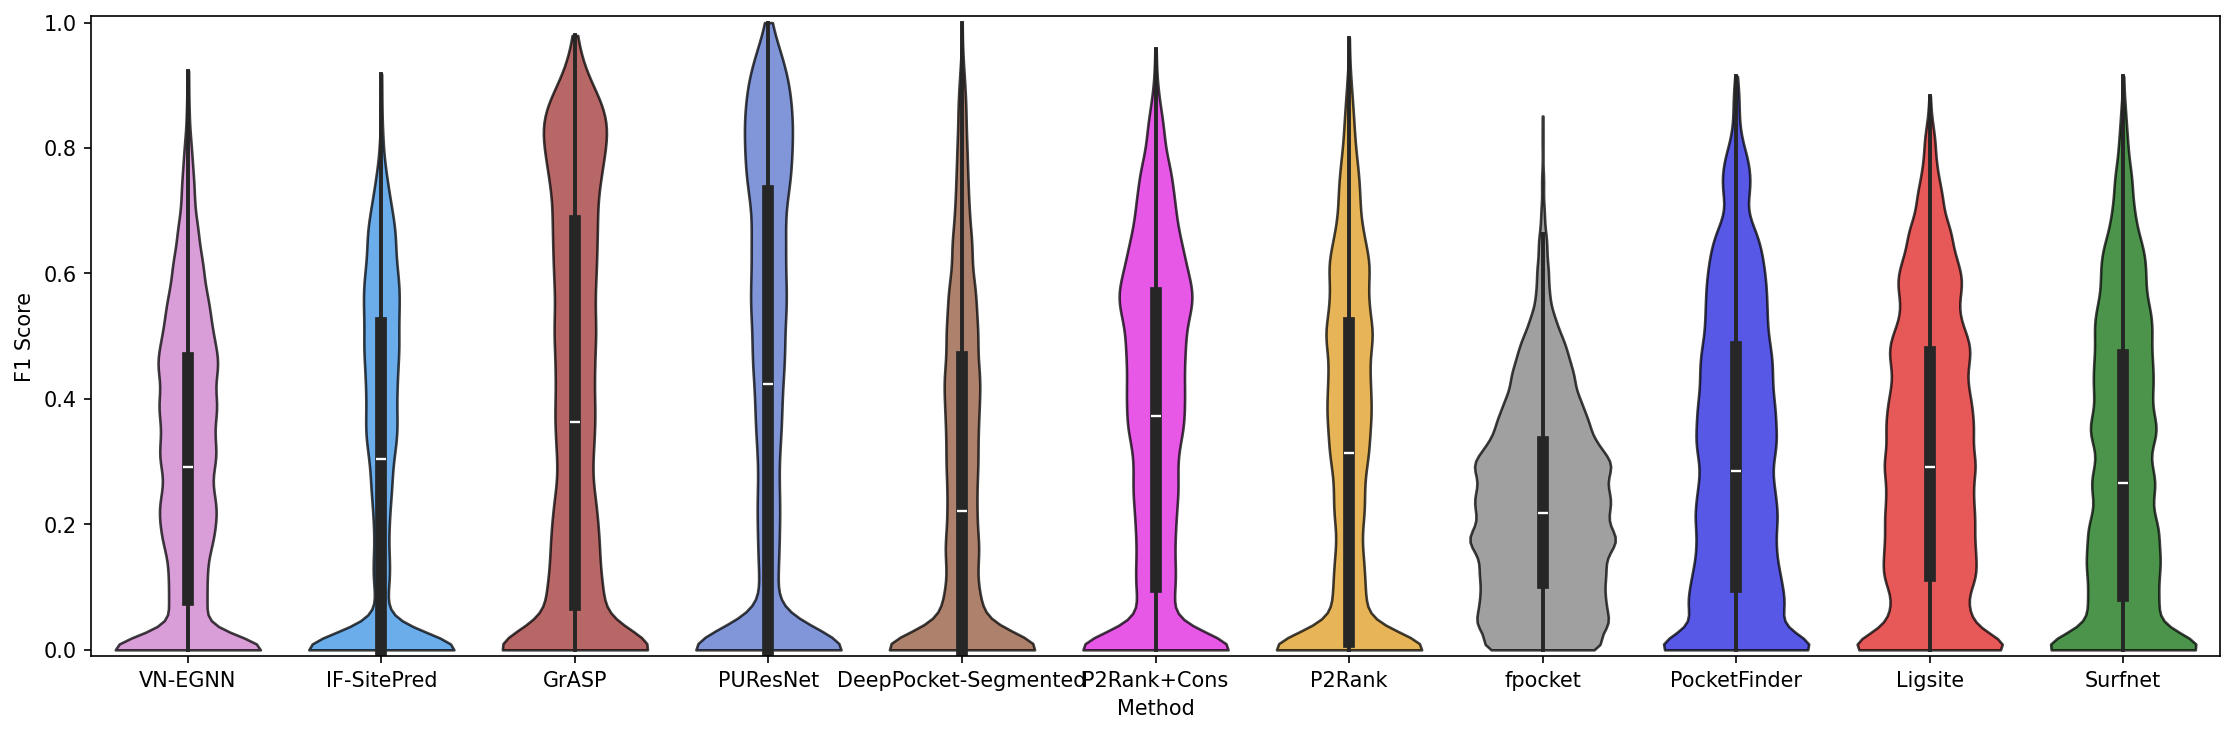

In [55]:
plt.figure(figsize=(15, 5), dpi=150)
ax = sns.violinplot(
    x="method", y="f1_score", data=f1_scores_df, palette=palette, cut=0,
    fill=True, linewidth=1.25, width=0.75, order=my_order, bw_adjust=0.5, inner = "box", alpha = 0.75,
)

# Manually set the edgecolor and facecolor for each violin
for violin in ax.collections:
    if isinstance(violin, PolyCollection):
        violin.set_edgecolor('k')  # Set edge color to black
        facecolor = violin.get_facecolor()
        facecolor[:, -1] = 0.15  # Set alpha for face color
        violin.set_facecolor(facecolor)

plt.xlabel('Method')
plt.ylabel('F1 Score')

plt.ylim(-0.01, 1.01)
plt.tight_layout()
#plt.savefig("./figs/F1_violins.png")
plt.show()

## Using ligandability scores (IF-SitePred, GrASP, P2Rank+Cons, P2Rank)

In [62]:
errors = []
dfs = []
for i, rep_chain in enumerate(LIGYSIS_reps):
    
    GRASP_scores_df = PDBXreader(inputfile = os.path.join(GRASP_preds_dir, f'{rep_chain}_probs.pdb')).atoms(format_type = "pdb", excluded=())
    #sorted_keys = custom_sort(GRASP_scores_dict.keys())
    GRASP_scores_dict = GRASP_scores_df.groupby('label_seq_id_full')['B_iso_or_equiv'].mean().round(2).to_dict()
    #GRASP_scores_dict = {key: GRASP_scores_dict[key] for key in sorted_keys}
    
    IFSP_scores_dict = read_from_pickle(os.path.join(IFSP_preds_dir, rep_chain, f'{rep_chain}_lig_scores.pkl')) # IFSP
    
    P2RANK_scores_df = pd.read_csv(os.path.join(P2RANK_preds_dir, f'{rep_chain}.trans.pdb_residues.csv')) #P2RANK
    P2RANK_scores_df = fix_col_names(P2RANK_scores_df)

    P2RANK_cons_scores_df = pd.read_csv(os.path.join(P2RANK_cons_preds_dir, f'{rep_chain}.trans.pdb_residues.csv')) #P2RANK_CONS
    P2RANK_cons_scores_df = fix_col_names(P2RANK_cons_scores_df)
    P2RANK_cons_scores_df.residue_label = P2RANK_cons_scores_df.residue_label.astype(str)
    P2RANK_cons_dict = dict(zip(P2RANK_cons_scores_df.residue_label, P2RANK_cons_scores_df.probability))

    PocketFinder_scores_df = PDBXreader(inputfile = os.path.join(PocketFinder_preds_dir, f'{rep_chain}.clean_pocketfinder_residue.pdb')).atoms(format_type = "pdb", excluded=())
    PocketFinder_score_dict = PocketFinder_scores_df.groupby('label_seq_id_full')['B_iso_or_equiv'].mean().round(2).to_dict()

    Ligsite_scores_df = PDBXreader(inputfile = os.path.join(Ligsite_preds_dir, f'{rep_chain}.clean_ligsite_residue.pdb')).atoms(format_type = "pdb", excluded=())
    Ligsite_score_dict = Ligsite_scores_df.groupby('label_seq_id_full')['B_iso_or_equiv'].mean().round(2).to_dict()

    Surfnet_scores_df = PDBXreader(inputfile = os.path.join(Surfnet_preds_dir, f'{rep_chain}.clean_surfnet_residue.pdb')).atoms(format_type = "pdb", excluded=())
    Surfnet_score_dict = Surfnet_scores_df.groupby('label_seq_id_full')['B_iso_or_equiv'].mean().round(2).to_dict()

    CORE_df = P2RANK_scores_df[["chain", "residue_label", "residue_name", "probability"]]
    CORE_df.rename(columns = {"residue_label": "resnum", "residue_name": "resname", "probability": "P2Rank"}, inplace = True)
    CORE_df.resnum = CORE_df.resnum.astype(str)
    CORE_df['resname'] = CORE_df['resname'].str.strip()
    CORE_df["rep_chain"] = rep_chain
    CORE_df["GrASP"] = CORE_df.resnum.map(GRASP_scores_dict)
    CORE_df["IF-SitePred"] = CORE_df.resnum.map(IFSP_scores_dict)
    CORE_df["P2Rank+Cons"] = CORE_df.resnum.map(P2RANK_cons_dict)
    CORE_df["PocketFinder"] = CORE_df.resnum.map(PocketFinder_score_dict)
    CORE_df["Ligsite"] = CORE_df.resnum.map(Ligsite_score_dict)
    CORE_df["Surfnet"] = CORE_df.resnum.map(Surfnet_score_dict)

    dfs.append(CORE_df)
    
ligandability_df = pd.concat(dfs).reset_index(drop = True)[["rep_chain", "chain", "resnum", "resname", "IF-SitePred", "GrASP", "P2Rank+Cons", "P2Rank", "PocketFinder", "Ligsite", "Surfnet"]]

In [65]:
ligandability_df

,rep_chain,chain,resnum,resname,IF-SitePred,GrASP,P2Rank+Cons,P2Rank,PocketFinder,Ligsite,Surfnet
0,1a52_A,A,10,LEU,0.11,0.00,0.0029,0.0159,0.03,0.00,0.00
1,1a52_A,A,11,ALA,0.20,0.00,0.0044,0.0168,0.02,0.00,0.00
2,1a52_A,A,12,LEU,0.24,0.00,0.0032,0.0104,0.01,0.00,0.00
3,1a52_A,A,13,SER,0.15,0.00,0.0007,0.0005,0.00,0.00,0.00
4,1a52_A,A,14,LEU,0.10,0.00,0.0032,0.0113,0.03,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
831567,8y6o_H,H,140,PRO,0.71,0.13,0.0668,0.0511,0.03,0.30,4.84
831568,8y6o_H,H,141,LYS,0.44,0.44,0.0669,0.0297,0.05,0.34,6.21
831569,8y6o_H,H,142,TYR,0.77,0.04,0.0617,0.0446,0.04,0.27,4.25
831570,8y6o_H,H,143,ASP,0.35,0.05,0.0070,0.0009,0.03,0.20,3.38


In [66]:
ligandability_df.to_pickle("./results/ligandability_df.pkl")

In [12]:
ligandability_df = pd.read_pickle("./results/ligandability_df.pkl")

In [19]:
ligandability_df["TRUE_LABEL"] = ligandability_df.set_index(["rep_chain", "chain", "resnum", "resname"]).index.map(TRUE_labels_dict.get)

In [20]:
len(ligandability_df.rep_chain.unique())#LIGYSIS_reps

2775

In [21]:
ligandability_df.head(3)

,rep_chain,chain,resnum,resname,IF-SitePred,GrASP,P2Rank+Cons,P2Rank,PocketFinder,Ligsite,Surfnet,TRUE_LABEL
0,1a52_A,A,10,LEU,0.11,0.0,0.0029,0.0159,0.03,0.0,0.0,0.0
1,1a52_A,A,11,ALA,0.20,0.0,0.0044,0.0168,0.02,0.0,0.0,0.0
2,1a52_A,A,12,LEU,0.24,0.0,0.0032,0.0104,0.01,0.0,0.0,0.0


In [22]:
ligandability_df_FILT = ligandability_df[~ligandability_df.isna().any(axis=1)].copy().reset_index(drop = True)
ligandability_df_FILT.TRUE_LABEL = ligandability_df_FILT.TRUE_LABEL.astype(int)

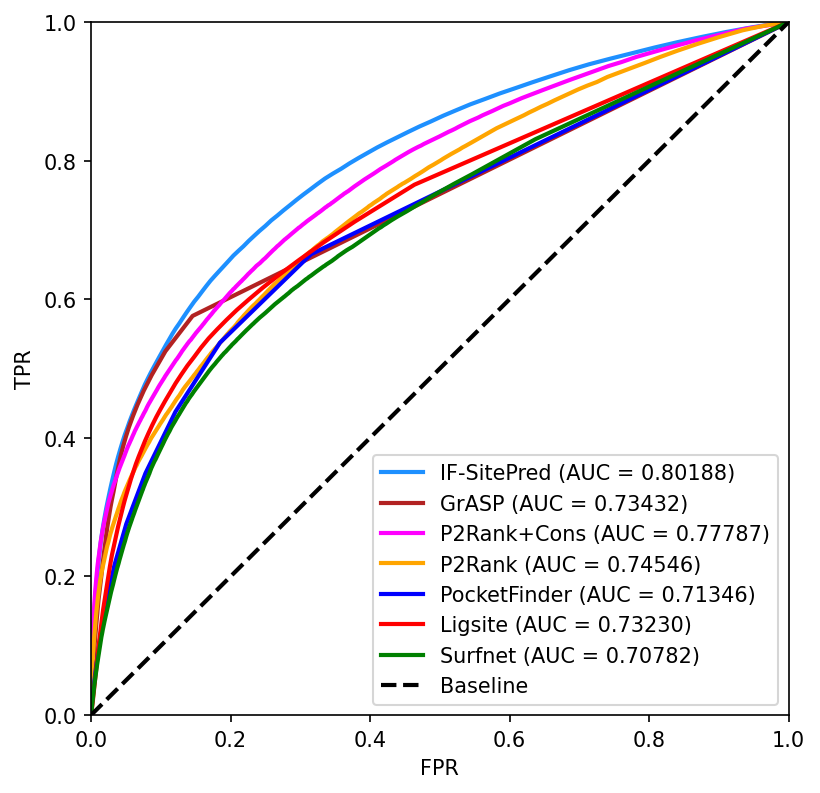

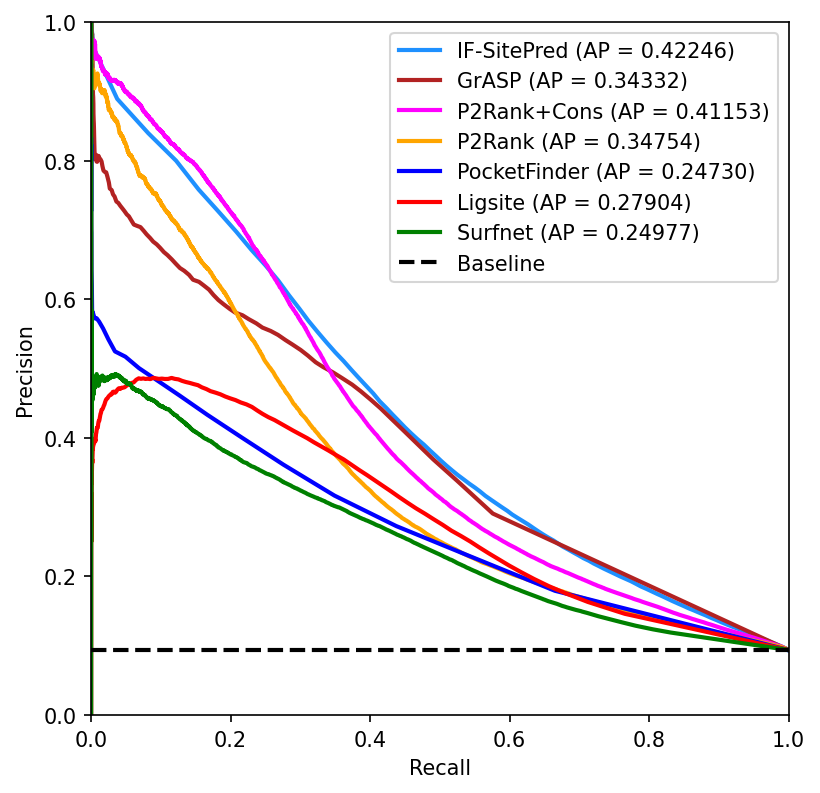

In [23]:
# Assuming you have the dataframe loaded as ligandability_df_FILT
methods = ['IF-SitePred', 'GrASP', 'P2Rank+Cons', 'P2Rank', 'PocketFinder', 'Ligsite', 'Surfnet']
true_label_col = 'TRUE_LABEL'

plot_roc_curve(
    ligandability_df_FILT, methods, true_label_col, palette,
    DPI = 150,
    #out = "./figs/ROC_AUC_residue_level_LEG.png"
)

plot_precision_recall_curve(
    ligandability_df_FILT, methods, true_label_col, palette,
    DPI = 150,
    #out = "./figs/PR_AUC_residue_level_LEG.png"
)

## Ligandability scores distribution

In [33]:
melted_df_lig_scores = ligandability_df.melt(id_vars=['rep_chain', 'chain', 'resnum', 'resname'], 
                    value_vars=['IF-SitePred', 'GrASP', 'P2Rank+Cons', 'P2Rank', 'PocketFinder', 'Ligsite', 'Surfnet'], 
                    var_name='method', value_name='score')

In [34]:
melted_df_lig_scores.query('score > 1 & resname != "UNK"').sort_values("score", ascending = False).method.value_counts()

Surfnet    258816
Ligsite      2640
Name: method, dtype: int64

In [35]:
#melted_df_lig_scores.query('method == "PocketFinder" & score > 1') # something wrong with 6bcu_A: IGNORE

#melted_df_lig_scores.query('method == "Ligsite" & score > 1')      --> normalising by setting score = 1 to all residues with score > 1 They are basically the deepest residues in each cavity,
                                                                    # and depending on how large/deep the cavity is, this can climb in value (largest is 2.5). Happens 2,640 times (1%)

#melted_df_lig_scores.query('method == "Surfnet" & score > 1')      --> normalising by setting score = 1 to all residues with score > 1 They are basically the deepest residues in each cavity,
                                                                    # and depending on how large/deep the cavity is, this can climb in value (largest is 54.2)

In [36]:
print(round(100*len(melted_df_lig_scores.query('score >= 0.5 and method == "IF-SitePred"'))/len(melted_df_lig_scores.query('method == "IF-SitePred"')), 2))

print(round(100*len(melted_df_lig_scores.query('score >= 0.5 and method == "GrASP"'))/len(melted_df_lig_scores.query('method == "GrASP"')), 2))

print(round(100*len(melted_df_lig_scores.query('score >= 0.5 and method == "P2Rank+Cons"'))/len(melted_df_lig_scores.query('method == "P2Rank+Cons"')), 2))

print(round(100*len(melted_df_lig_scores.query('score >= 0.5 and method == "P2Rank"'))/len(melted_df_lig_scores.query('method == "P2Rank"')), 2))

23.25
0.75
2.81
3.05


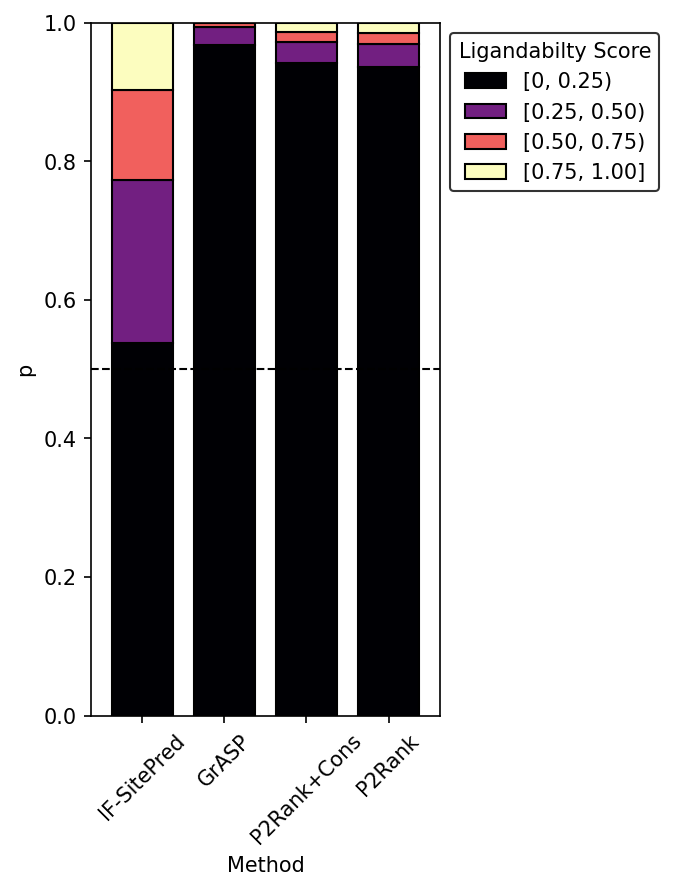

In [37]:
ls_mets = ['IF-SitePred', 'GrASP', 'P2Rank+Cons', 'P2Rank']
#melted_df_lig_scores_NORM = normalise_scores(melted_df_lig_scores, ['PocketFinder', 'Ligsite', 'Surfnet'])
# Example usage with 4 bins
plot_stacked_bar(
    melted_df_lig_scores.query('method in @ls_mets'),
    4, order = ls_mets, DPI = 150,
    #out = "./figs/LS_barplot.png"
)

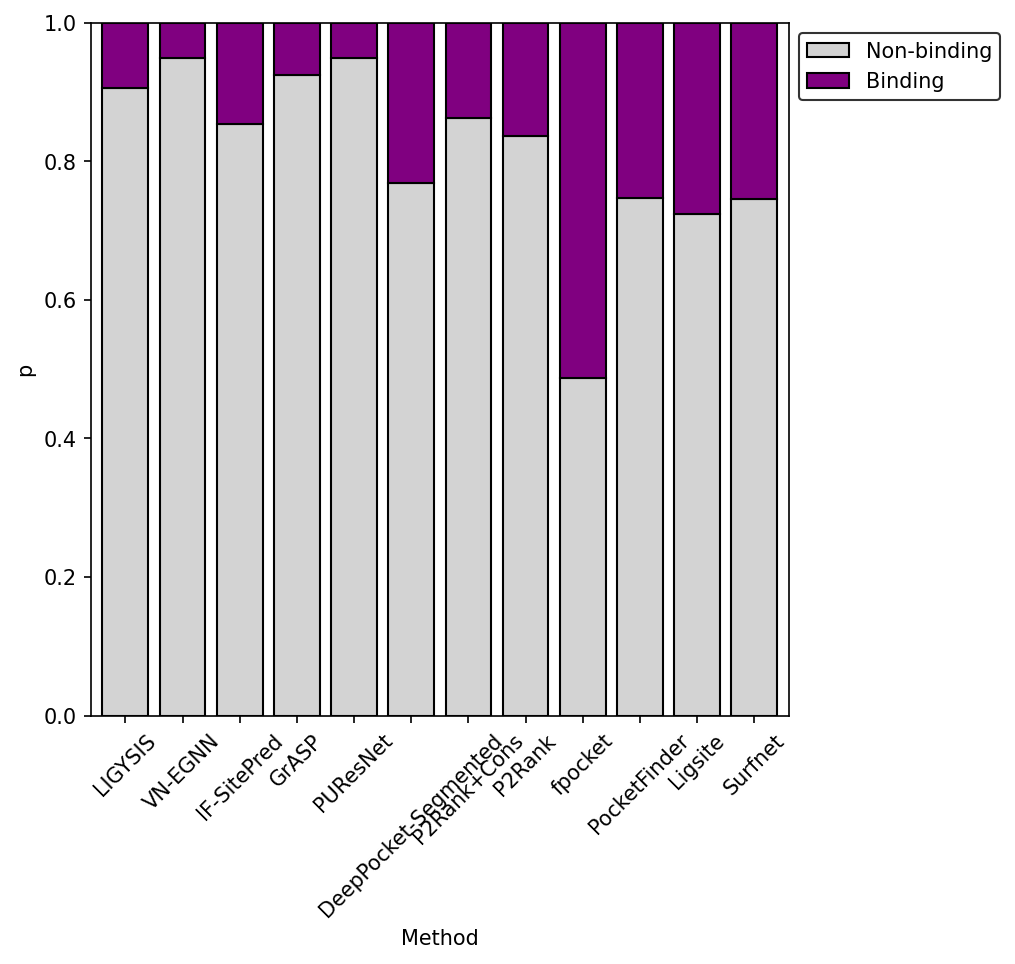

In [58]:
plot_stacked_bars(
    df,
    [
        "LIGYSIS", "VN-EGNN", "IF-SitePred", "GrASP", "PUResNet", "DeepPocket-Segmented",
        "P2Rank+Cons", "P2Rank", "fpocket", "PocketFinder", "Ligsite", "Surfnet"
    ],DPI = 150)